In [1]:
from braket.aws import AwsQuantumJob, AwsSession
from braket.jobs.local import LocalQuantumJob
from braket.jobs.image_uris import Framework, retrieve_image
import time
import pickle

# aws_session = AwsSession(default_bucket="amazon-braket-eu-west-2-lukasvoss")
aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")

In [2]:
# "arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy"

device = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

parts = device.split('/')
# Access the last element
device_name = parts[-1]

In [3]:
num_total_updates = 50

hyperparams = {
    "num_total_updates": num_total_updates, 
}

#Name your job so that it can be later identified
job_name = f'cx-gate-calibration-{num_total_updates}-updates-{str(int(time.time()))}-{device_name}'

# Specify one of the ready-to-use containers provided by Amazon Braket
# image_uri = retrieve_image(Framework.PL_PYTORCH, AwsSession().region)

q_env_config_path = 'config_yamls/q_env_gate_config.yaml'
agent_config_path = 'config_yamls/agent_config.yaml'

input_config = {
    'q-env-config': q_env_config_path,
    'agent-config': agent_config_path,
}

In [4]:
job = AwsQuantumJob.create(
    #Run this hybrid job on the SV1 simulator
    device=device,
    #The directory or single file containing the code to run.
    source_module="needed_files",
    #The main script or function the job will run.
    entry_point="needed_files.algorithm_script:calibrate_gate",
    #Set the name of the job
    job_name=job_name,
    # Set the hyperparameters
    hyperparameters=hyperparams,
    # Specify the image to use for the container to run the script in
    # image_uri=image_uri,
    # Define the file that contains the input data but not relevant for the minimal example
    input_data=input_config,
    wait_until_complete=True,
    aws_session=aws_session,
)

Initializing Braket Job: arn:aws:braket:us-west-1:229406906664:job/cx-gate-calibration-50-updates-1708493715-sv1
......................
2024-02-21 05:37:35,694 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-21 05:37:35,695 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-02-21 05:37:35,708 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-21 05:37:35,709 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-02-21 05:37:35,721 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-02-21 05:37:35,722 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-02-21 05:37:35,734 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "agent-config": "/opt/ml/inp

In [5]:
training_results = job.result()

In [6]:
while job.state() not in job.TERMINAL_STATES:
    print(job.state())
    time.sleep(30)

print(job.state())
print(job.result())

COMPLETED
{'avg_reward': [0.25765609377098514, 0.2304017930916376, 0.2908607023508982, 0.3490981040192995, 0.3807491061057047, 0.269463925666916, 0.3844297544976477, 0.40898193694424667, 0.240047604040732, 0.260475402500944, 0.42111420189630683, 0.45873318977095723, 0.5031614678058235, 0.43519372372968906, 0.23870340274365903, 0.43131735945002353, 0.4979689990939435, 0.5032002483905286, 0.4452639432749352, 0.23587413897197496, 0.44469271724944465, 0.2589025104065887, 0.25590080721372854, 0.49357230236350746, 0.5081451653195563, 0.2711092431689738, 0.2584252481516813, 0.5170135686159011, 0.2572306555420575, 0.25874966540414157, 0.41711813128976405, 0.559463080300832, 0.24224431662116802, 0.3742230818272507, 0.25471831491972985, 0.26153529044045803, 0.5176231925277058, 0.23498321703104103, 0.2547614110290145, 0.24731020211320273, 0.48531715402125486, 0.2570908740004421, 0.25075119220994646, 0.2652695399328451, 0.5737182276933819, 0.6101154751466344, 0.24911630719800834, 0.257310026192221

In [7]:
pickle_name = job_name + '.pickle'

with open(job_name, 'wb') as handle:
    pickle.dump(job.result(), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
avg_reward = training_results['avg_reward']
std_actions = training_results['std_actions']

fidelities = training_results['fidelities']

#### Visualize results

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

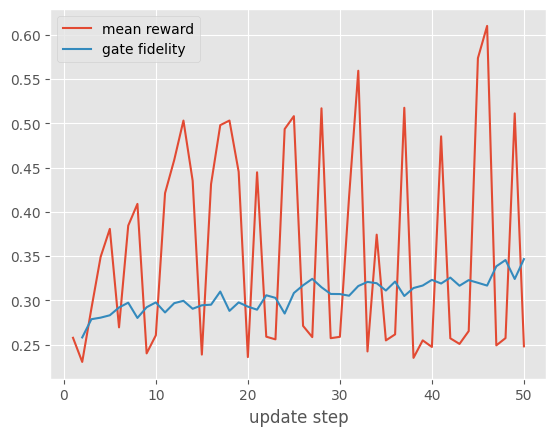

In [10]:
plt.plot(np.arange(1, num_total_updates+1), avg_reward, label='mean reward')
plt.plot(np.arange(2, num_total_updates+1), fidelities, label='gate fidelity')
plt.xlabel('update step')
plt.legend()

In [11]:
print(f'Final Gate Fidelity: {fidelities[-1]:.4%}')
print(f'\nMax Gate Fidelity: {max(fidelities):.4%}')

Final Gate Fidelity: 34.6601%

Max Gate Fidelity: 34.6601%


In [12]:
std_actions_componentwise = list(zip(*std_actions))

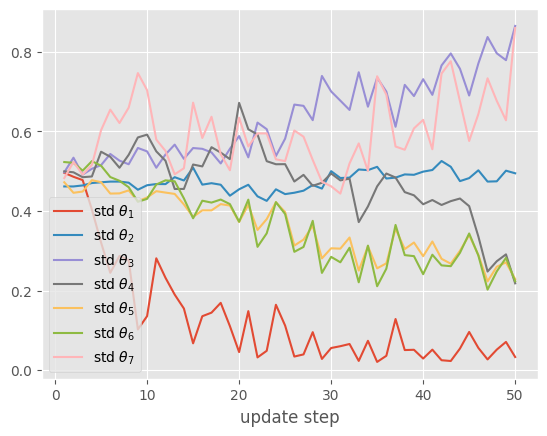

In [13]:
for ind, param in enumerate(std_actions_componentwise):
    plt.plot(np.arange(1, num_total_updates+1), param, label=r'std $\theta_{}$'.format(ind+1))

plt.xlabel('update step')
plt.legend()

#### Best Action Vector

In [18]:
best_action_vector = avg_action_history[np.argmax(fidelities)]

In [19]:
best_action_vector

[-0.0029411064460873604,
 -0.1571265012025833,
 0.29162338376045227,
 -0.06424690783023834,
 0.054243527352809906,
 -0.01653566211462021,
 -0.3298453688621521]